# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

new_rides = rides[['hour','cab_type','price','distance','date']].dropna(subset = ['price']).reset_index()
new_rides['distance'] = new_rides.progress_apply(lambda row: math.ceil(row['distance']), axis=1)
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

cab_types_ = new_rides.cab_type.unique()
distances_ = new_rides.distance.unique()
hours_ = np.array([16,17,18,19,20])  # new_rides.hour.unique()
prices_ = np.array([0,5,10,15])# np.array([5*(i) for i in range(5)])  # new_rides.price.unique()
dates = len(new_rides.date.unique())

g = np.zeros((len(cab_types_),len(prices_),len(hours_),len(distances_)))

for i in range(len(cab_types_)):
    for j in trange(len(prices_)):
        for k in range(len(hours_)):
            for m in range(len(distances_)):
                g[i,j,k,m] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
                                          &(new_rides['price']==prices_[j])
                                          &(new_rides['hour']==hours_[k])
                                          &(new_rides['distance']==distances_[m])])/dates

np.random.seed(37)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.17s/it]


# Configurations

In [3]:
x = [17,2]  # [time, distance]
g_uber = np.sum(g[np.where(cab_types_=='Uber'),:,:,np.where(distances_==x[1])], axis=3).reshape((-1,1))
g_lyft = np.sum(g[np.where(cab_types_=='Lyft'),:,:,np.where(distances_==x[1])], axis=3).reshape((-1,1))

prices_ = prices_.reshape((-1,1))

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 1e0
lambda_p2 = 1e0

eta_p1 = 1e-2
eta_p2 = 1e-2

mu_p1 = -0.07*g_uber
gamma_p1 = 0.02*g_uber
mu_p2 = -0.07*g_lyft
gamma_p2 = 0.02*g_lyft

In [4]:
p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
p2_data_generating_func = sample_from_location_family_rideshare

In [5]:
num_rounds_lst = np.logspace(1,5,5,dtype='int')
num_test = 1000
num_alternate_rounds = 1000
num_games = 1000

# Run game with 2-stage algorithm

In [6]:
np.random.seed(0)
r1_ = []
r2_ = []

for game in trange(num_games):
    p1_risks = []
    p2_risks = []

    for num_samples in num_rounds_lst:
        rounds_1 = max(math.floor(0.8*num_samples),num_samples-1000)
        rounds_2 = num_samples-rounds_1
        player_one = TwoStagePlayer()
        player_two = TwoStagePlayer()
        game_ts = DecisionDependentGame(player_one, player_two,
                                        p1_data_params, p2_data_params,
                                        p1_data_generating_func, p2_data_generating_func,
                                        rounds_1, rounds_2, num_test)

        game_ts.run_train()
        game_ts.run_post_train_alternating()

        PR1 = game_ts.evaluate_perf_risk_p1()
        PR2 = game_ts.evaluate_perf_risk_p2()

        p1_risks.append(PR1)
        p2_risks.append(PR2)

    r1_.append(p1_risks)
    r2_.append(p2_risks)
    
r1_avg = np.mean(np.array(r1_),axis=0)
r2_avg = np.mean(np.array(r2_),axis=0)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [6:33:36<00:00, 23.62s/it]


# Run game with DFO players

In [7]:
np.random.seed(0)
r3_ = []
r4_ = []

delta = 4e-1
eta = 1e-1
num_test_dfo = 100
num_rounds = num_rounds_lst[-1]

for game in trange(num_games):
    p3_risks = []
    p4_risks = []

    player_three = DFOPlayer(delta,eta)
    player_four = DFOPlayer(delta,eta)
    game_dfo = DecisionDependentGame(player_three, player_four,
                                     p1_data_params, p2_data_params,
                                     p1_data_generating_func, p2_data_generating_func,
                                     num_test = num_test_dfo)

    for i in range(math.ceil(num_rounds/2/num_test_dfo)+1):

        theta31, theta32 = player_three.perturb_theta()
        theta41, theta42 = player_four.perturb_theta()

        game_dfo.theta_p1 = theta31
        game_dfo.theta_p2 = theta41
        pr31 = game_dfo.evaluate_perf_risk_p1()
        pr41 = game_dfo.evaluate_perf_risk_p2()

        game_dfo.theta_p1 = theta32
        game_dfo.theta_p2 = theta42
        pr32 = game_dfo.evaluate_perf_risk_p1()
        pr42 = game_dfo.evaluate_perf_risk_p2()

        game_dfo.theta_p1 = player_three.update_theta(pr31, pr32)
        game_dfo.theta_p2 = player_four.update_theta(pr41, pr42)

        if i*2*num_test_dfo >= num_rounds_lst[len(p3_risks)]:
            p3_risks.append(np.mean(np.array(game_dfo.p1.risk_history[max(-i,-1000)])))
            p4_risks.append(np.mean(np.array(game_dfo.p2.risk_history[max(-i,-1000)])))
            
    r3_.append(p3_risks)
    r4_.append(p4_risks)
    
r3_avg = np.mean(np.array(r3_),axis=0)
r4_avg = np.mean(np.array(r4_),axis=0)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:59<00:00,  5.57it/s]


## Plots

In [8]:
base_uber = -np.dot(g_uber.T,prices_)[0,0]
base_lyft = -np.dot(g_lyft.T,prices_)[0,0]

num_rounds_lst = np.insert(num_rounds_lst,0,1)
r1_avg = np.insert(r1_avg,0,base_uber)
r2_avg = np.insert(r2_avg,0,base_lyft)
r3_avg = np.insert(r3_avg,0,base_uber)
r4_avg = np.insert(r4_avg,0,base_lyft)

hi = math.floor(-0.025*num_games)
lo = math.floor(0.25*num_games)

r1 = np.array(r1_)
r1_sort = np.sort(r1, axis=0)
r1_hi = np.insert(r1_sort[hi],0,base_uber)
r1_lo = np.insert(r1_sort[lo],0,base_uber)
r2 = np.array(r2_)
r2_sort = np.sort(r2, axis=0)
r2_hi = np.insert(r2_sort[hi],0,base_lyft)
r2_lo = np.insert(r2_sort[lo],0,base_lyft)
r3 = np.array(r3_)
r3_sort = np.sort(r3, axis=0)
r3_hi = np.insert(r3_sort[hi],0,base_uber)
r3_lo = np.insert(r3_sort[lo],0,base_uber)
r4 = np.array(r4_)
r4_sort = np.sort(r4, axis=0)
r4_hi = np.insert(r4_sort[hi],0,base_lyft)
r4_lo = np.insert(r4_sort[lo],0,base_lyft)

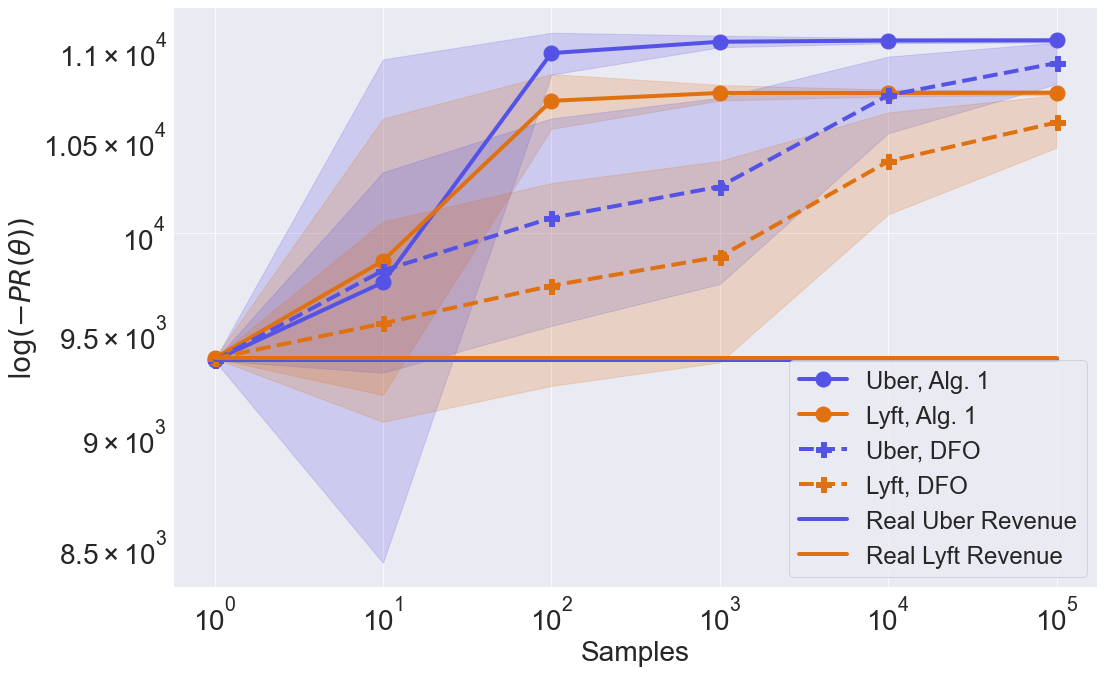

In [9]:
plt.rcParams['font.size'] = 28
plt.rcParams['axes.linewidth'] = 4
plt.figure(figsize=(16,10))

plt.loglog(num_rounds_lst, -np.squeeze(r1_avg),
           '-', color='#5553E6', label='Uber, Alg. 1', lw=4, marker='o', markersize=15)
plt.loglog(num_rounds_lst, -np.squeeze(r2_avg),
           '-', color='#E07110', label='Lyft, Alg. 1', lw=4, marker='o', markersize=15)
plt.fill_between(num_rounds_lst, -r1_hi, -r1_lo, color='#5553E6', alpha=0.2)
plt.fill_between(num_rounds_lst, -r2_hi, -r2_lo, color='#E07110', alpha=0.2)

plt.loglog(num_rounds_lst, -np.squeeze(r3_avg),
             '--', color='#5553E6', label='Uber, DFO', lw=4, marker='P', markersize=15)
plt.loglog(num_rounds_lst, -np.squeeze(r4_avg),
             '--', color='#E07110', label='Lyft, DFO', lw=4, marker='P', markersize=15)
plt.fill_between(num_rounds_lst, -r3_hi, -r3_lo, color='#5553E6', alpha=0.2)
plt.fill_between(num_rounds_lst, -r4_hi, -r4_lo, color='#E07110', alpha=0.2)

plt.loglog(num_rounds_lst, [np.dot(g_uber.T,prices_)[0,0] for i in range(len(num_rounds_lst))],
             '-', color='#5553E6', label='Real Uber Revenue', lw=4)
plt.loglog(num_rounds_lst, [np.dot(g_lyft.T,prices_)[0,0] for i in range(len(num_rounds_lst))],
             '-', color='#E07110', label='Real Lyft Revenue', lw=4)

plt.xlabel("Samples")
plt.ylabel(r"$\log(-PR(\theta))$")
plt.legend(fontsize=24,loc='lower right')

plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()